In [1]:
# Package segmentation using Mask R-CNN from PyTorch

import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import cv2
import distinctipy

from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2 as T
from torchvision.transforms.v2 import functional as TF

from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
# Verify if CUDA is available
torch.cuda.is_available()

True

In [3]:
# Define the dataset class
class UltralyticsPackageSegDataset(Dataset):
	def __init__(self, root, transforms=None, set_name='train'):
		self.root = root
		self.transforms = transforms
  
		# Read the image and annotation files
		img_files = glob.glob(os.path.join(root, set_name, 'images', '*.jpg'))
  
		self.imgs = []
		self.masks = []
		self.boxes = []
		self.labels = []
  
		self.n_classes = 2
		self.class_names = ['background', 'package']
  
		self.read_data(img_files)
  
	def read_data(self, img_files):
		for img_file in img_files:
			# Read the image
			img = cv2.imread(img_file)
			img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
			# Read the annotation
			annot_file = img_file.replace('images', 'labels').replace('.jpg', '.txt')
			with open(annot_file, 'r') as f:
				annotation = f.read()

			if annotation == '':
				continue

			# Parse the annotation
			lines = annotation.strip().split('\n')

			# Initialize the lists for boxes, masks, and labels
			boxes = []
			masks = []
			labels = []
			for line in lines:
				# Parse the line
				entities = line.split(' ')
				label = int(entities[0]) + 1
				poly_points = entities[1:]
    
				# Convert polygon points from list of strings to list of tuples of floats
				points = []
				for i in range(0, len(poly_points), 2):
					x = float(poly_points[i]) * img.shape[1]
					y = float(poly_points[i+1]) * img.shape[0]
					points.append((x, y))
     
				# Convert polygon points to mask
				mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
				pts = np.array(points, np.int32)
				cv2.fillPoly(mask, [pts], 1)
				mask = mask.reshape((1, img.shape[0], img.shape[1]))
				masks.append(mask)

				# Convert polygon points to bounding box
				xmin, ymin = np.min(pts, axis=0)
				xmax, ymax = np.max(pts, axis=0)
				boxes.append([xmin, ymin, xmax, ymax])
				labels.append(label)
    
			masks = Mask(torch.concat([Mask(mask, dtype=torch.bool) for mask in masks]))
			boxes = BoundingBoxes(np.array(boxes), format='xyxy', canvas_size=(img.shape[0], img.shape[1]))
			labels = torch.tensor(labels, dtype=torch.int64)
    
			self.imgs.append(TF.to_tensor(img))
			self.masks.append(masks)
			self.boxes.append(boxes)
			self.labels.append(labels)

	def __getitem__(self, idx):
		img = self.imgs[idx]
		masks = self.masks[idx]
		boxes = self.boxes[idx]
		labels = self.labels[idx]
  
		target = {
			'masks': masks,
			'boxes': boxes,
			'labels': labels
		}
  
		if self.transforms is not None:
			img, target = self.transforms(img, target)

		return img, target

	def __len__(self):
		return len(self.imgs)

In [4]:
# Data augmentation
data_augmentation = T.Compose([
    T.RandomHorizontalFlip(0.5),
])

# Bounding box sanitize and normalization
data_sanitization = T.Compose([
	T.ToImage(),
	T.ToDtype(torch.float32, scale=True),
	T.SanitizeBoundingBoxes(),
])

# Train and validation transforms
train_transforms = T.Compose([
	data_augmentation,
	data_sanitization,
])

val_transforms = T.Compose([
	data_sanitization,
])

In [5]:
# Load the dataset
dataset_train = UltralyticsPackageSegDataset(root='data/package_seg', transforms=train_transforms, set_name='train')
dataset_val = UltralyticsPackageSegDataset(root='data/package_seg', transforms=val_transforms, set_name='valid')

print('Number of samples in the training dataset:', len(dataset_train))
print('Number of samples in the validation dataset:', len(dataset_val))

# Create the dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=4, collate_fn=lambda x: tuple(zip(*x)))
dataloader_val = DataLoader(dataset_val, batch_size=4, collate_fn=lambda x: tuple(zip(*x)))

/home/malolan/.personal_projects/instance_segmentation/venv/lib/python3.10/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(


Number of samples in the training dataset: 1803
Number of samples in the validation dataset: 176


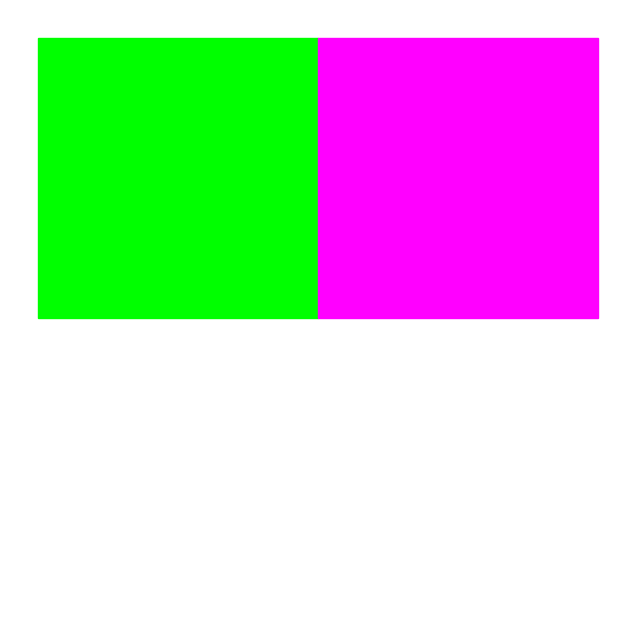

In [6]:
# Create a color map
colors = distinctipy.get_colors(dataset_train.n_classes)

# Visualise color map
distinctipy.color_swatch(colors)

# Convert colors to 0-255 range
colors = [(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in colors]

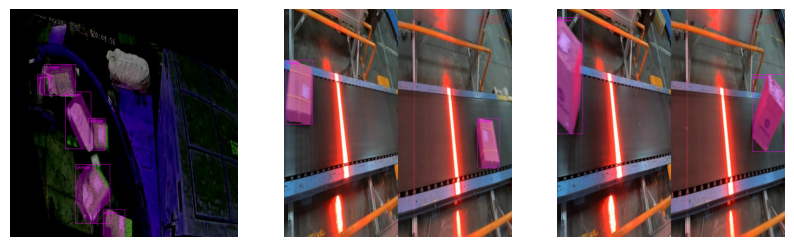

In [7]:
# Visualise the first 3 images with annotations
fig = plt.figure(figsize=(10, 10))

for i in range(3):
	img, target = dataset_train[i]

	annotated_img = draw_segmentation_masks(
		image=img,
		masks=target['masks'],
		alpha=0.3,
		colors=[colors[label] for label in target['labels']],
	)
 
	annotated_img = draw_bounding_boxes(
		image=annotated_img,
		boxes=target['boxes'],
		labels=[dataset_train.class_names[label] for label in target['labels']],
		colors=[colors[label] for label in target['labels']],
	)
 
	annotated_img = annotated_img.permute(1, 2, 0).numpy()
 
	ax = fig.add_subplot(1, 3, i+1)
	ax.imshow(annotated_img)
	ax.axis('off')
 
plt.show()

In [8]:
# Define the training function
def train_one_epoch(model, optimizer, dataloader, device):
	model.train()
	losses = []
	for images, targets in tqdm(dataloader):
		images = list(image.to(device) for image in images)
		targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
		loss_dict = model(images, targets)
		losses.append(loss_dict['loss_box_reg'])
		optimizer.zero_grad()
		loss_dict['loss_box_reg'].backward()
		optimizer.step()
	
	return losses

# Define the validation function
def validate(model, dataloader, device):
	model.train()
	losses = []
	for images, targets in tqdm(dataloader):
		images = list(image.to(device) for image in images)
		targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
		with torch.no_grad():
			loss_dict = model(images, targets)
			losses.append(loss_dict['loss_box_reg'])
	return losses

In [9]:
# Function to create the model
def get_model(n_classes):
	# Load the pre-trained model
	model = maskrcnn_resnet50_fpn_v2(pretrained=True)
	in_features_box = model.roi_heads.box_predictor.cls_score.in_features
	in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

	# Number of output channels for the mask predictor
	out_channels_mask = model.roi_heads.mask_predictor.conv5_mask.out_channels

	# Replace the box and mask predictors
	model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, n_classes)
	model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, out_channels_mask, n_classes)
 
	return model

# Create the model
model = get_model(dataset_train.n_classes)

# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('Device:', device)

model.to(device)

# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

/home/malolan/.personal_projects/instance_segmentation/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/malolan/.personal_projects/instance_segmentation/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda


In [14]:
# Train the model for 25 epochs
n_epochs = 25

for epoch in range(n_epochs):
	train_losses = train_one_epoch(model, optimizer, dataloader_train, device)
	val_losses = validate(model, dataloader_val, device)
	print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {torch.stack(train_losses).mean()}, Val Loss: {torch.stack(val_losses).mean()}')
 
	# Save the model as a checkpoint
	if (epoch+1) % 5 == 0:
		if not os.path.exists('checkpoints'):
			os.makedirs('checkpoints')
		torch.save(model.state_dict(), f'checkpoints/mask_rcnn_model_epoch_{epoch+1}.pth')
 
# Save the model
torch.save(model.state_dict(), 'mask_rcnn_model.pth')

# Also save optimizer state for resuming training
torch.save(optimizer.state_dict(), 'optimizer.pth')

100%|██████████| 44/44 [00:16<00:00,  2.70it/s]


Epoch 1/25, Train Loss: 0.0229363813996315, Val Loss: 0.03365249186754227


100%|██████████| 44/44 [00:13<00:00,  3.26it/s]


Epoch 2/25, Train Loss: 0.023347774520516396, Val Loss: 0.03469984605908394


100%|██████████| 44/44 [00:09<00:00,  4.47it/s]


Epoch 3/25, Train Loss: 0.022642750293016434, Val Loss: 0.039592817425727844


100%|██████████| 44/44 [00:12<00:00,  3.66it/s]


Epoch 4/25, Train Loss: 0.021761463955044746, Val Loss: 0.03831799328327179


100%|██████████| 44/44 [00:08<00:00,  5.11it/s]


Epoch 5/25, Train Loss: 0.021528230980038643, Val Loss: 0.03662954643368721


100%|██████████| 44/44 [00:11<00:00,  3.97it/s]


Epoch 6/25, Train Loss: 0.021833891049027443, Val Loss: 0.03392554447054863


100%|██████████| 44/44 [00:10<00:00,  4.34it/s]


Epoch 7/25, Train Loss: 0.021973585709929466, Val Loss: 0.03124534711241722


100%|██████████| 44/44 [00:13<00:00,  3.37it/s]


Epoch 8/25, Train Loss: 0.022650428116321564, Val Loss: 0.028017668053507805


100%|██████████| 44/44 [00:07<00:00,  5.59it/s]


Epoch 9/25, Train Loss: 0.023159446194767952, Val Loss: 0.028138045221567154


100%|██████████| 44/44 [00:12<00:00,  3.54it/s]


Epoch 10/25, Train Loss: 0.021536314859986305, Val Loss: 0.027711734175682068


100%|██████████| 44/44 [00:08<00:00,  5.26it/s]


Epoch 11/25, Train Loss: 0.02080744132399559, Val Loss: 0.027629802003502846


100%|██████████| 44/44 [00:07<00:00,  5.90it/s]


Epoch 12/25, Train Loss: 0.020756373181939125, Val Loss: 0.02963937446475029


100%|██████████| 44/44 [00:09<00:00,  4.60it/s]


Epoch 13/25, Train Loss: 0.02139657735824585, Val Loss: 0.031442079693078995


100%|██████████| 44/44 [00:10<00:00,  4.23it/s]


Epoch 14/25, Train Loss: 0.020496109500527382, Val Loss: 0.03119242563843727


100%|██████████| 44/44 [00:22<00:00,  1.96it/s]


Epoch 15/25, Train Loss: 0.019598310813307762, Val Loss: 0.035622596740722656


100%|██████████| 44/44 [00:11<00:00,  3.84it/s]


Epoch 16/25, Train Loss: 0.01900889165699482, Val Loss: 0.03881508484482765


100%|██████████| 44/44 [00:11<00:00,  3.71it/s]


Epoch 17/25, Train Loss: 0.02017577365040779, Val Loss: 0.03787615895271301


100%|██████████| 44/44 [00:10<00:00,  4.38it/s]


Epoch 18/25, Train Loss: 0.02032109908759594, Val Loss: 0.0359359085559845


100%|██████████| 44/44 [00:13<00:00,  3.31it/s]


Epoch 19/25, Train Loss: 0.020177410915493965, Val Loss: 0.03331753984093666


100%|██████████| 44/44 [00:09<00:00,  4.56it/s]


Epoch 20/25, Train Loss: 0.019389713183045387, Val Loss: 0.02860225923359394


100%|██████████| 44/44 [00:12<00:00,  3.63it/s]


Epoch 21/25, Train Loss: 0.019034497439861298, Val Loss: 0.029622238129377365


100%|██████████| 44/44 [00:09<00:00,  4.69it/s]


Epoch 22/25, Train Loss: 0.01975218951702118, Val Loss: 0.02825254015624523


100%|██████████| 44/44 [00:10<00:00,  4.34it/s]


Epoch 23/25, Train Loss: 0.01839013583958149, Val Loss: 0.027390610426664352


100%|██████████| 44/44 [00:07<00:00,  5.80it/s]


Epoch 24/25, Train Loss: 0.01901939883828163, Val Loss: 0.02721456252038479


100%|██████████| 44/44 [00:10<00:00,  4.35it/s]


Epoch 25/25, Train Loss: 0.01893449015915394, Val Loss: 0.02830815687775612


In [ ]:
# Load the model
model = get_model(dataset_train.n_classes)
model.to(device)
model.load_state_dict(torch.load('mask_rcnn_model.pth'))

# Also load the optimizer state
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer.load_state_dict(torch.load('optimizer.pth'))

In [13]:
# Run one validation epoch
val_losses = validate(model, dataloader_val, device)
print('Validation loss:', torch.stack(val_losses).mean().item())

100%|██████████| 44/44 [00:09<00:00,  4.55it/s]

Validation loss: 0.036431360989809036


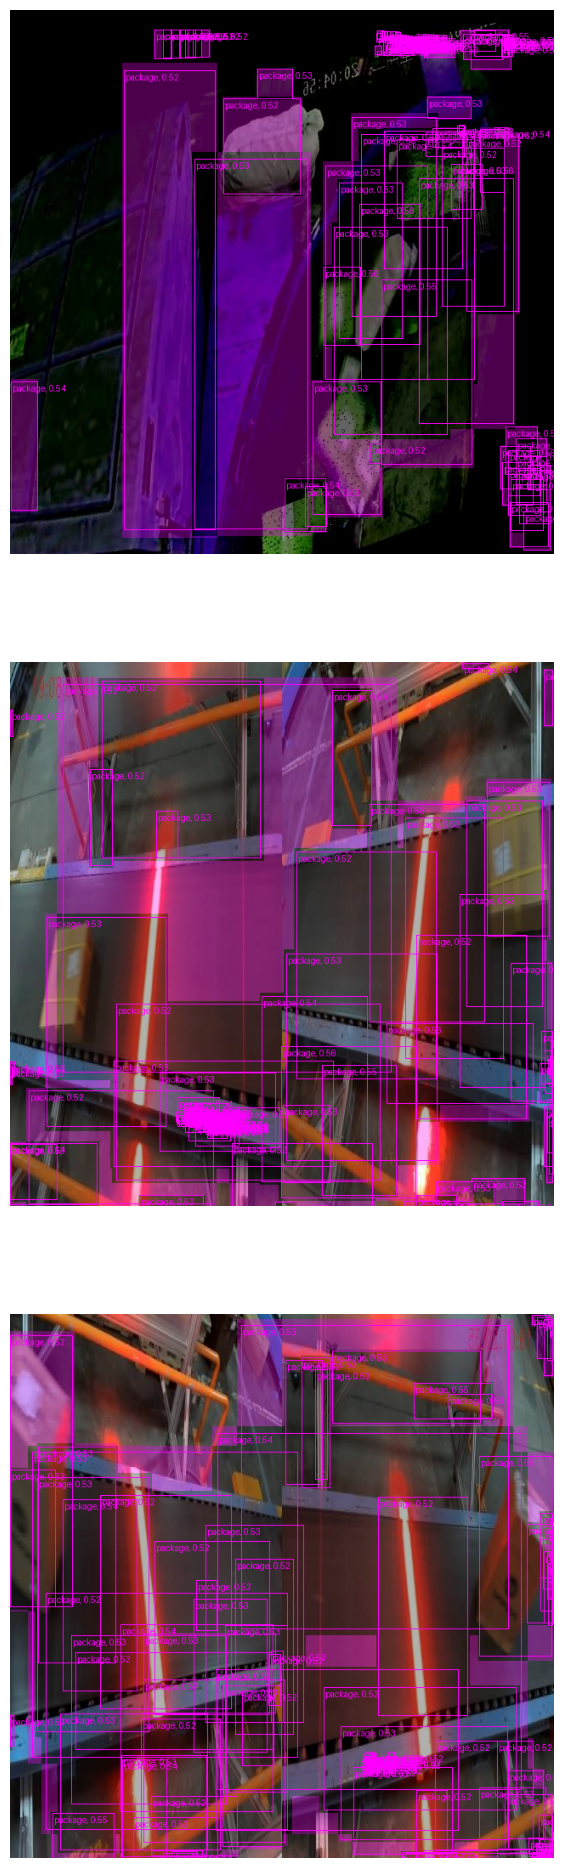

In [16]:
# Run the model on 3 samples from the validation dataset and visualise the results
model.eval()
model.to(device)

fig = plt.figure(figsize=(24, 24))

for i in range(3):
	img, target = dataset_train[i]
	img = img.unsqueeze(0).to(device)
	target = [{k: v.to(device) for k, v in target.items()}]

	output = model(img, target)
	output_masks = output[0]['masks'].cpu()
	output_boxes = output[0]['boxes'].cpu()
	output_labels = output[0]['labels'].cpu()
	output_scores = output[0]['scores'].cpu()
 
	# Reshape masks from (N, 1, H, W) to (N, H, W)
	output_masks = output_masks.squeeze(1)

	# Convert masks to boolean
	output_masks = output_masks.type(torch.bool)

	# Remove masks and boxes with scores below a threshold
	threshold = 0.5
	output_masks = output_masks[output_scores > threshold]
	output_boxes = output_boxes[output_scores > threshold]
	output_labels = output_labels[output_scores > threshold]

	annotated_img = draw_segmentation_masks(
		image=img[0],
		masks=output_masks,
		alpha=0.3,
		colors=[colors[label] for label in output_labels],
	)
 
	annotated_img = draw_bounding_boxes(
		image=annotated_img,
		boxes=output_boxes,
		labels=[f"{dataset_train.class_names[label]}, {score.item():.2f}" for label, score in zip(output_labels, output_scores)],
		colors=[colors[label] for label in output_labels],
	)
 
	annotated_img = annotated_img.permute(1, 2, 0).cpu().numpy()

	ax = fig.add_subplot(3, 1, i+1)
	ax.imshow(annotated_img)
	ax.axis('off')
 
plt.show()